In [70]:
%pylab inline
%load_ext autoreload
%autoreload 2
from gekkolib import gekkoapi
from model import preprocessing
import datetime as dt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [195]:
candles_raw = gekkoapi.pull_candles('kraken', 'ETH', 'EUR', candlesize=60)#, date_start=dt.date(2019,6,1))

In [234]:
candles = candles_raw.copy()
candles.head()

,close,high,low,open,start,trades,volume,vwp
0,0.85353,0.85353,0.85353,0.85353,1451608440,1,25.000000,0.85353
1,0.85353,0.85353,0.85353,0.85353,1451612040,0,0.000000,0.85353
2,0.85353,0.85353,0.85353,0.85353,1451615640,0,0.000000,0.85353
3,0.85353,0.85353,0.85353,0.85353,1451619240,0,0.000000,0.85353
4,0.87127,0.87127,0.85353,0.85353,1451622840,1,11.011011,0.87127


In [235]:
logcols = ['close', 'high', 'low', 'open']
candles[logcols] = candles[logcols].applymap(log)

In [236]:
candles.shape

(30904, 8)

In [237]:
candles.head()

,close,high,low,open,start,trades,volume,vwp
0,-0.158375,-0.158375,-0.158375,-0.158375,1451608440,1,25.000000,0.85353
1,-0.158375,-0.158375,-0.158375,-0.158375,1451612040,0,0.000000,0.85353
2,-0.158375,-0.158375,-0.158375,-0.158375,1451615640,0,0.000000,0.85353
3,-0.158375,-0.158375,-0.158375,-0.158375,1451619240,0,0.000000,0.85353
4,-0.137803,-0.137803,-0.158375,-0.158375,1451622840,1,11.011011,0.87127


In [238]:
# target -- rolling max
candles['target'] = candles.close.rolling(20).apply(max, raw=True)

In [239]:
ss = StandardScaler()
scaled_candles = ss.fit_transform(candles)
scaled_candles = pd.DataFrame(scaled_candles, columns=candles.columns)

In [240]:
windows, target = preprocessing.create_windows(scaled_candles, 20, 1, target='target')

In [241]:
windows.shape

(30884, 20, 8)

In [242]:
target.shape

(30884, 1)

In [243]:
windows.shape

(30884, 20, 8)

In [244]:
windows.reshape(windows.shape[0], -1).shape

(30884, 160)

# Deep Learning Skeleton

In [293]:
from torch.utils.data import DataLoader, TensorDataset

def get_data(train_ds, val_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(val_ds, batch_size=bs * 2),
    )

def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            print(xb.shape, yb.shape)
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        print(epoch, val_loss)

# Create Model

In [315]:
import torch
from torch import nn
import torch.nn.functional as F
lossf = torch.nn.MSELoss()

def build_fc_model():
    model = nn.Sequential(
        nn.Linear(160, 40),
        nn.ReLU(),
#         nn.Linear(40, 40),
#         nn.ReLU(),
        nn.Linear(40, 1),
    )
    return model



In [309]:
from torch import Tensor, optim

In [310]:
# windows_t = Tensor(windows.reshape(windows.shape[0], -1))
windows_t = Tensor(windows)
target_t = Tensor(target) #.view(-1, 1, 1)
windows_ds = TensorDataset(windows_t, target_t)
train, val = train_test_split(windows_ds)
train = DataLoader(train, 64)
val = DataLoader(train, 64)

In [311]:
windows_t.shape

torch.Size([30884, 20, 8])

In [312]:
target_t.shape

torch.Size([30884, 1])

In [314]:
opt = optim.Adam(model.parameters(), lr=0.01)

In [332]:
fit(5, model, lossf, opt, train, val)

torch.Size([64, 20, 8]) torch.Size([64, 1])


TypeError: relu(): argument 'input' (position 1) must be Tensor, not tuple

In [252]:
valx, _, valy, _ = train_test_split(windows.reshape(windows.shape[0], -1), target, train_size=0.8)
valx = Tensor(valx)
valy = Tensor(valy)

In [253]:
valx.shape

torch.Size([24707, 160])

In [259]:
with torch.no_grad():
    preds = model(valx)

Text(0, 0.5, 'pred')

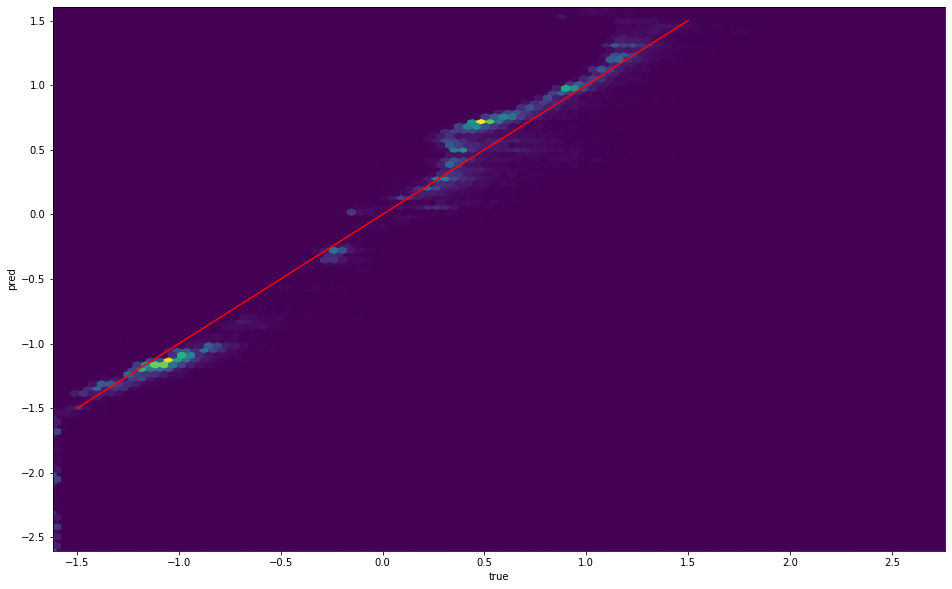

In [265]:
plt.figure(figsize=(16,10))
# plt.hexbin(preds.detach().numpy(), valy.numpy(), bins='log')
ident = [-1.5, 1.5]
plt.hexbin(preds.numpy(), valy.numpy())
plt.plot(ident, ident, c='r')
plt.xlabel('true')
plt.ylabel('pred')

# GRU

In [392]:
class GRUModel:
    def __init__(self, lr):
        self.gru = nn.GRU(8, 4, num_layers=1, batch_first=True)

        self.post = nn.Sequential(
            nn.Linear(4, 4),
            nn.ReLU(),
            nn.Linear(4, 1),
        )
        self.lossf = nn.MSELoss()
        self.opt = optim.Adam([*self.gru.parameters(), *self.post.parameters()], lr=lr)
    
    def get_data(self, train_ds, val_ds, bs):
        return (
            DataLoader(train_ds, batch_size=bs, shuffle=True),
            DataLoader(val_ds, batch_size=bs * 2),
        )

    def loss_batch(self, xb, yb, opt=None):
        print('new batch')
        print(xb.shape)
        d = self.gru(xb)[1]
        print(d.shape)
        d = self.post(d)
        print(d.shape, yb.shape)
        loss = self.lossf(d, yb)
        print(loss.shape)

        if opt is not None:
            loss.backward()
            opt.step()
            opt.zero_grad()

        return loss.item(), len(xb)

    def fit(self, epochs, train_dl, valid_dl):
        for epoch in range(epochs):
            self.gru.train()
            self.post.train()
            for xb, yb in train_dl:
                self.loss_batch(xb, yb, self.opt)

            self.gru.eval()
            self.post.eval()
            with torch.no_grad():
                losses, nums = zip(
                    *[self.loss_batch(xb, yb) for xb, yb in valid_dl]
                )
            val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            print(epoch, val_loss)

grumodel = GRUModel(lr=0.01)

In [393]:
windows_t = Tensor(windows)
target_t = Tensor(target) #.view(-1, 1, 1)
windows_ds = TensorDataset(windows_t, target_t)
train, val = train_test_split(windows_ds)
train = DataLoader(train, 64)
val = DataLoader(val, 128)

In [394]:
windows_t.shape

torch.Size([30884, 20, 8])

In [395]:
target_t.shape

torch.Size([30884, 1])

In [396]:
val

In [397]:
grumodel.fit(1, train, val)

new batch
torch.Size([64, 20, 8])
torch.Size([1, 64, 4])
torch.Size([1, 64, 1]) torch.Size([64, 1])
torch.Size([])
new batch
torch.Size([64, 20, 8])
torch.Size([1, 64, 4])
torch.Size([1, 64, 1]) torch.Size([64, 1])
torch.Size([])
new batch
torch.Size([64, 20, 8])
torch.Size([1, 64, 4])
torch.Size([1, 64, 1]) torch.Size([64, 1])
torch.Size([])
new batch
torch.Size([64, 20, 8])
torch.Size([1, 64, 4])
torch.Size([1, 64, 1]) torch.Size([64, 1])
torch.Size([])
new batch
torch.Size([64, 20, 8])
torch.Size([1, 64, 4])
torch.Size([1, 64, 1]) torch.Size([64, 1])
torch.Size([])
new batch
torch.Size([64, 20, 8])
torch.Size([1, 64, 4])
torch.Size([1, 64, 1]) torch.Size([64, 1])
torch.Size([])
new batch
torch.Size([64, 20, 8])
torch.Size([1, 64, 4])
torch.Size([1, 64, 1]) torch.Size([64, 1])
torch.Size([])
new batch
torch.Size([64, 20, 8])
torch.Size([1, 64, 4])
torch.Size([1, 64, 1]) torch.Size([64, 1])
torch.Size([])
new batch
torch.Size([64, 20, 8])
torch.Size([1, 64, 4])
torch.Size([1, 64, 1]) 

KeyboardInterrupt: 